In [1]:
import gc # garbage collector
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [2]:
LISTE_MAJ = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
LISTE_MIN = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
LISTE_NBR = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

BATCH_SIZE = 256
EPOCHS = 10
ADD_NOM = "3_b" + str(BATCH_SIZE) + "_e" + str(EPOCHS)

In [3]:
# shape of the image : 50x50
# number of classes : 62 (26 letters majuscules, 26 letters minuscules, 10 chiffres)

# Dataset_Min_test : 597_728
# Dataset_Min_train : 1_787_408
# Dataset_Min_validation : 597_984

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [4]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données

In [5]:
def fetch_data(nom_collection: str, nbr: int):
    collection = db[nom_collection]  # Nom de la collection
    documents = collection.find()
    print(f"fetch {nom_collection} OK !!!")

    images = []
    labels = []
    types = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            types.append(doc["Type"])
            pbar.update(1) # Mettre à jour la barre de progression
            
    # return np.array(images), np.array(labels, dtype=str)
    return pd.DataFrame({"Labels": labels, "Types": types, "Images": images})

### Récupérations des données de toutes les collections
---

In [9]:
df_min_test = fetch_data("Dataset_Min_test", 597_728)
df_min_test = df_min_test.sample(frac=1).reset_index(drop=True)
print(df_min_test.shape)
df_min_test.head()
# Temps : 1m 9.1s

fetch Dataset_Min_test OK !!!


Proccessing: 100%|██████████| 597728/597728 [01:08<00:00, 8681.44it/s] 


(597728, 3)


,Labels,Types,Images
0,c,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,e,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,a,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [10]:
df_min_train = fetch_data("Dataset_Min_train", 1_787_408)
df_min_train = df_min_train.sample(frac=1).reset_index(drop=True)
print(df_min_train.shape)
df_min_train.head()
# Temps : 3m 18.5s 

fetch Dataset_Min_train OK !!!


Proccessing: 100%|██████████| 1787408/1787408 [03:17<00:00, 9041.65it/s] 


(1787408, 3)


,Labels,Types,Images
0,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,r,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,l,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,j,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
df_min_validation = fetch_data("Dataset_Min_validation", 597_984)
df_min_validation = df_min_validation.sample(frac=1).reset_index(drop=True)
print(df_min_validation.shape)
df_min_validation.head()
# Temps : 1m 36.4s

fetch Dataset_Min_validation OK !!!


Proccessing: 100%|██████████| 597984/597984 [01:36<00:00, 6223.29it/s]


(597984, 3)


,Labels,Types,Images
0,e,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,x,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,h,Min,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,l,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,r,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Données pour apprentissage du NN 'Get Min'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Min' qui permettra de classé les images selon la lettre minuscule qui y est representée.

In [ ]:
X_train_Min = np.array(df_min_train["Images"].tolist())
# Temps : 

In [ ]:
y_train_Min = np.array(df_min_train["Labels"].tolist())
# Temps : 

In [ ]:
X_test_Min = np.array(df_min_test["Images"].tolist())
# Temps : 

In [ ]:
y_test_Min = np.array(df_min_test["Labels"].tolist())
# Temps : 

In [ ]:
X_validation_Min = np.array(df_min_validation["Images"].tolist())
# Temps : 

In [ ]:
y_validation_Min = np.array(df_min_validation["Labels"].tolist())
# Temps : 

In [35]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Min = LabelEncoder()

y_train_Min_2 = label_encoder_Min.fit_transform(y_train_Min)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Min_2 = label_encoder_Min.transform(y_test_Min)
y_validation_Min_2 = label_encoder_Min.transform(y_validation_Min)

In [36]:
# Correspondance indices ↔ labels
correspondance_Min = dict(enumerate(label_encoder_Min.classes_))
print(correspondance_Min)

# Liste des labels
labels_Min = list(correspondance_Min.values())
print(labels_Min)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [37]:
# Afficher quelques informations
print(f"Taille de X_train_Min: {X_train_Min.shape}, y_train_Min: {y_train_Min.shape}, y_train_Min_2: {y_train_Min_2.shape}")
print(f"Taille de X_test_Min: {X_test_Min.shape}, y_test_Min: {y_test_Min.shape}, y_test_Min_2: {y_test_Min_2.shape}")
print(f"Taille de X_validation_Min: {X_validation_Min.shape}, y_validation_Min: {y_validation_Min.shape}, y_validation_Min_2: {y_validation_Min_2.shape}")

Taille de X_train_Min: (1787408, 625), y_train_Min: (1787408,), y_train_Min_2: (1787408,)
Taille de X_test_Min: (597728, 625), y_test_Min: (597728,), y_test_Min_2: (597728,)
Taille de X_validation_Min: (597984, 625), y_validation_Min: (597984,), y_validation_Min_2: (597984,)


##### Suppression
---

Suppression des données pour l'apprentissage de 'Get Min' plus utilisées

In [38]:
del df_min_test, df_min_train, df_min_validation
gc.collect()  # Force la collecte des objets non utilisés

0

# Get Min (NN)
---

Modèle ...

In [54]:
model_get_min = keras.Sequential([
    keras.layers.Input((625,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(26, activation='softmax') # output layer : 26 neurones (A-Z)
])

model_get_min.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
model_get_min.fit(
    X_train_Min, 
    y_train_Min_2, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(
        X_validation_Min, 
        y_validation_Min_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9293
# loss : 0.2193
# Temps : 2m 45.3s

# Batch 64
# accuracy : 0.9328
# loss : 0.2042
# Temps : 2m 2.7s

# Batch 128
# accuracy : 0.9332
# loss : 0.2038
# Temps : 58.4s

# Batch 256
# accuracy : 0.9338
# loss : 0.2036
# Temps : 38.3s

Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.7831 - loss: 0.7784 - val_accuracy: 0.8790 - val_loss: 0.4012
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.8917 - loss: 0.3579 - val_accuracy: 0.8913 - val_loss: 0.3649
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9046 - loss: 0.3115 - val_accuracy: 0.8970 - val_loss: 0.3508
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9140 - loss: 0.2789 - val_accuracy: 0.9003 - val_loss: 0.3457
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.9185 - loss: 0.2544 - val_accuracy: 0.8980 - val_loss: 0.3569
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9245 - loss: 0.2383 - val_accuracy: 0.9015 - val_loss: 0.3499
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9273 - loss: 0.2265 - val_accuracy: 0.9026 - val_loss: 0.3516
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9315 - loss: 0.2135 - 

In [56]:
test_loss_min, test_acc_min = model_get_min.evaluate(X_test_Min, y_test_Min_2)
print(f"Test accuracy : {test_acc_min}") # Test accuracy : 
print(f"Test loss : {test_loss_min}") # Test loss : 
# Temps : 

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9064 - loss: 0.3524
Test accuracy : 0.9053750038146973
Test loss : 0.3557049036026001


In [57]:
# Sauvegarder le modèle
model_get_min.save("../models/Get_Min_v" + ADD_NOM + ".keras")  # Format keras (.keras)

In [58]:
y_predicted_Min = model_get_min.predict(X_test_Min)
y_predicted_Min[1]

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([3.7943786e-01, 1.4323607e-03, 9.1954082e-01, 1.4593005e-04,
       6.7862546e-01, 8.1423724e-01, 2.5948825e-01, 3.8280867e-02,
       5.3159217e-04, 9.3061998e-03, 1.8773583e-03, 6.1412263e-01,
       1.7699229e-03, 7.5359094e-01, 2.6605953e-03, 8.3907443e-01,
       4.4839466e-03, 9.9999994e-01, 3.9724717e-01, 9.9751401e-01,
       4.5803140e-06, 2.6060769e-01, 1.5482088e-09, 1.5511469e-05,
       9.7040340e-02, 2.2374501e-05], dtype=float32)

In [59]:
# y_predicted_labels_Min = [correspondance_Min[np.argmax(i)] for i in y_predicted_Min]
y_predicted_labels_Min = [np.argmax(i) for i in y_predicted_Min]
y_predicted_labels_Min[:5]

[19, 17, 10, 19, 19]

Text(95.72222222222221, 0.5, 'Truth')

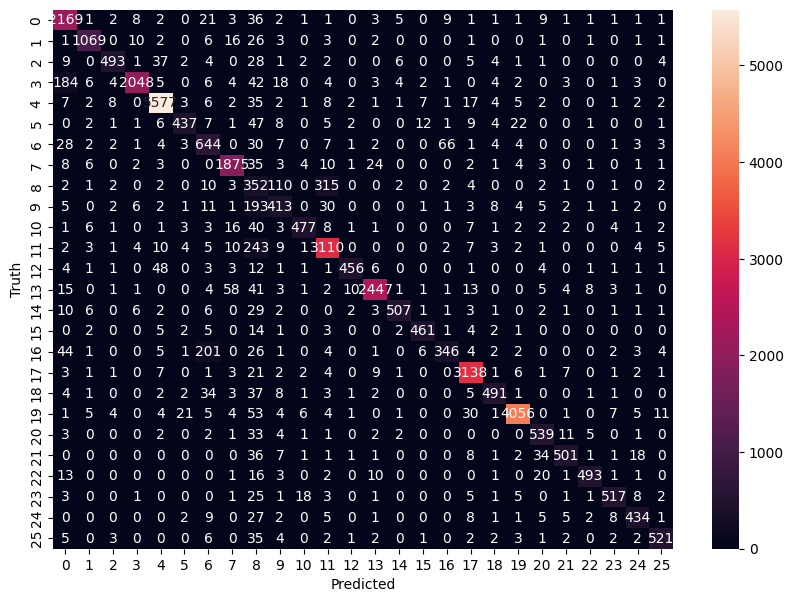

In [60]:
# Matrice de confusion
cm_Min = tf.math.confusion_matrix(labels=y_test_Min_2, predictions=y_predicted_labels_Min)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Min, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')